In [1]:
#Studnet: Jhuma kabir meem
#Exercise Bayes' theorem liklyhood


In [154]:
# -- initialize the device
!pip install pycuda
import numpy as np
import pycuda.driver as cuda
import pycuda.autoinit
import pycuda.gpuarray as gpuarray
import numpy as np
from pycuda import driver, compiler, gpuarray, tools
import pycuda.autoinit
import math

In [195]:
# Test bayes therorem with python CPU
 
from numba import jit, cuda
import numpy as np
# to measure exec time
from timeit import default_timer as timer  

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels import api
from scipy import stats
from scipy.optimize import minimize 
 
# Generate some synthetic data based on the assumption of Normal Distribution.
# generate an independent variable 
x = np.linspace(-10, 30, 100)
# generate a normally distributed residual
e = np.random.normal(10, 5, 100)
theta1=10
theta2= 4
# generate ground truth
y = theta1 + theta2*x + e


features = api.add_constant(df.x)
model = api.OLS(y, features).fit()
model.summary() 
res = model.resid
standard_dev = np.std(res)

print('Standard deviation is:', standard_dev)
# MLE function
# ml modeling and neg LL calculation
def MLE_Norm(parameters):
  # extract parameters
  const, beta, std_dev = parameters
  # predict the output
  pred = const + beta*x
  # Calculate the log-likelihood for normal distribution
  LL = np.sum(stats.norm.logpdf(y, pred, std_dev))
  # Calculate the negative log-likelihood
  neg_LL = -1*LL
  return neg_LL 
# Minimize the negative log-likelihood of the generated data using the minimize method available with SciPy’s optimize module.
# minimize arguments: function, intial_guess_of_parameters, method
mle_model = minimize(MLE_Norm, np.array([2,2,2]), method='L-BFGS-B')

Standard deviation is: 4.169702430021818


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Estimated stdev: 8.010424055651127
Estimated Mean: 59.754208
2.5459286e-20


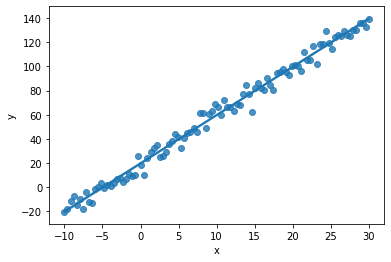

Ground truth stdev 4.169702430021818


In [200]:
# Test bayes therorem with python GPU

import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
import matplotlib.pyplot as plt
import time


# generate an independent variable 
x = np.linspace(-10, 30, 100)
# generate a normally distributed residual
e = np.random.normal(10, 5, 100)
theta1=10
theta2= 4
# generate ground truth
y = theta1 + theta2*x + e

start = cuda.Event()
end  = cuda.Event()

size=len(x)

XS = np.array(y).astype(np.float32) # delcare array 
a = gpuarray.to_gpu(XS)

w= np.zeros(len(a)).astype(np.float32)
w = gpuarray.to_gpu(w)


#This is ML estimate of the moments:
mean=np.mean(XS)
sum_XS=0
for i in XS:
  sum_XS=+ (i-mean)**2
stdev = math.sqrt( 1 / (len(XS) - 1) *sum_XS ) 

print('Estimated stdev:', stdev)
print('Estimated Mean:', mean)

# GPU karnel all funtion
mod = SourceModule("""

__global__ void linearm(
    float theta_1, float theta_2, int N,
    const float* xs, const float* noise,
    float* ys)
{
    uint index = blockDim.x * blockIdx.x + threadIdx.x;

    ys[index] = theta_1 + xs[index] * theta_1 + noise[index];
}


__global__ void normal_pdf( const float* xs, float mean, float stdev,  float* ws)
{  
    
    uint index = blockDim.x * blockIdx.x + threadIdx.x;

    float var = stdev * stdev;
    float Z = 1.f / sqrt(M_2_PI * var);
    float diff = xs[threadIdx.x] - mean;
    float arg = -0.5 * diff * diff / var; 
    ws[index] = Z * exp(arg); 
}

__global__ void log_normal(const float* xs, float mean, float stdev,  float* ws)
{
    uint index = blockDim.x * blockIdx.x + threadIdx.x;
    float var = stdev * stdev; // sigma^2
    float Z = 1.f / sqrt(M_2_PI * var);
    float diff = xs[threadIdx.x] - mean;
    float arg = -0.5 * diff * diff / var; 

    ws[index] = log(Z) + arg;
}
__global__ void normalise_ws(
    float* ws, float* ws_normal)
{   float max_w=-1.3;
    uint index = blockDim.x * blockIdx.x + threadIdx.x;

    ws_normal[index] = exp(ws[index] - max_w);
}
    """)


start.record()

log_normal = mod.get_function("normal_pdf")
log_normal(a, np.float32(mean), np.float32(stdev), w,  block=(size, 1, 1))
WS = np.array(w.get()).astype(np.float32) 

#un_ws = call the kernel log_normal
log_normal = mod.get_function("log_normal")
log_normal(a, np.float32(mean), np.float32(stdev), w,  block=(size, 1, 1))
WS = np.array(w.get()).astype(np.float32) 
ws = gpuarray.to_gpu(WS)

#ws = call the kernel normalise_ws
WS_normal= np.zeros(len(WS)).astype(np.float32)
ws_normal = gpuarray.to_gpu(WS_normal)
# print(ws)

normalise_ws = mod.get_function("normalise_ws")
normalise_ws(ws, ws_normal,  block=(size, 1, 1))


end.record() 
end.synchronize()

ws=ws_normal.get()
# print(p[0])

from scipy.stats import lognorm

for i in range(len(ws)):
  l=ws[i]*XS[i]
  s=+ l
print(s)


df = pd.DataFrame({'x':x, 'y':y})
df.head() 
sns.regplot(x='x', y='y', data = df)
plt.show()


print('Ground truth stdev', standard_dev)


# print(y)
# print(sum.get())

# print(max(sum.get()))
# print(ws_normal.get())